# Quantum Linear Systems Problem

## Overview

The quantum linear system problem (QLSP) is a quantum variant of the linear system problem $Ax=b$. Given access to an invertible matrix $A$ and a normalized quantum state $|b\rangle$, QLSP asks for a construction of the solution quantum state
$$ |x\rangle := A^{-1}|b\rangle / ||A^{-1}|b\rangle ||_2 $$
with bounded error.

Suppose the condition number of the coefficient matrix is $\kappa := ||A||_2 / ||A^{-1}||_2$ and $A \in \mathbb{C}^{N \times N}$. There are near-optimal quantum algorithms for solving QLSP with bounded error $\epsilon$ and complexity $\tilde{O}(\kappa \log(1/\epsilon) \text{ polylog}(N))$. In this example, we will deploy a much simpler construction of the solution to QLSP (sacrificing total complexity for pedagogy).

## The equivalent problem in function approximation

The immediate idea for solving QLSP is approximately implementing the map $A \mapsto A^{-1}$. Hence, in light of QSP, the implementation boilds down to a scalar function $f(x) = x^{-1}$. Without loss of generality, we assume the matrix is normalized so that $||A||_2 \leq 1$. Then, the condition number implies that the eigenvalues of $A$ lie in the interval $D_\kappa := [-1,-\kappa]\cup[\kappa, 1]$. We seek to find an odd polynomial approximation to $f(x)$ on the interval $D_\kappa$ so as to exclude the singularity of $f(x)$ at $x=0$.

## Setup

For the sake of this demonstration, we set $\kappa = 10$. To improve the numerical stability of our methods, we scale down the target function by a factor of $1/(2\kappa) = 1/20$ so that
$$ f(x) = \frac{1}{2\kappa x}, \quad \max_{x\in D_\kappa} |f(x)| = \frac{1}{2}. $$

In [1]:
kappa = 10
targ = lambda x: 1/(2*kappa*x)
deg = 151
parity = deg % 2

## Polynomial approximation

To numerically find the best polynomial approximating $f(x)$ on the interval $D_\kappa$, we use a subroutine which solves the problem using convex optimization. We first set the parameters of the subroutine.

In [2]:
import numpy as np

opts = {
    'intervals': [1/kappa, 1],
    'objnorm': np.inf,
    'epsil': 0.01,
    'npts': 500,
    'fscale': 1,
    'isplot': True,
    'method': 'cvxpy'
}

Then, simply calling our subroutine yields the coefficients of the approximation polynomial in the Chebyshev basis. Since the solver outputs all coefficients, we post-select those of odd order due to the parity constraint.

norm error = 1.2780815006330215e-07
max of solution = 0.909880628720708


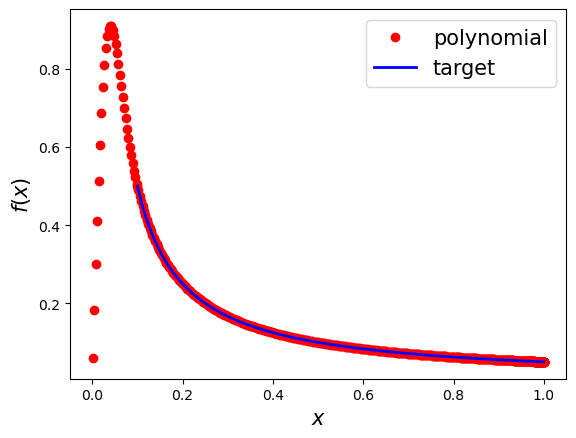

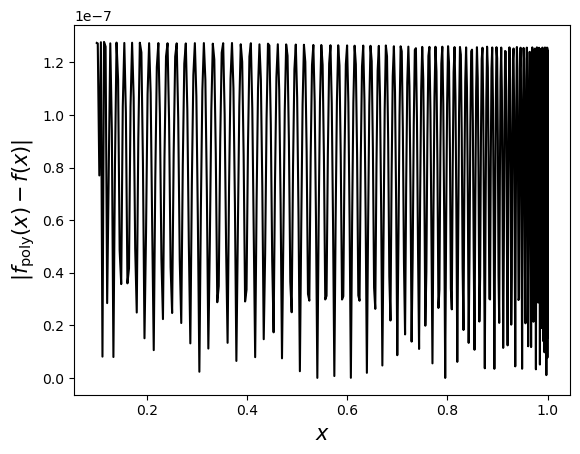

In [3]:
from qsppack.utils import cvx_poly_coef

coef_full = cvx_poly_coef(targ, deg, opts)
coef = coef_full[parity::2]

Above we see that both the $\ell_\infty$-error from the optimization scheme and the maximum value of the solution are outputted by `cvx_poly_coef`. The former verifies suitable convergence, the latter verifies that our polynomial satisfies the constraints. Additionally, since `isplot=True`, plots of the polynomial approximation and its error are shown.

## Solving the phase factors for QLSP

We will now initialize the parameters of the solver for finding phase factors using Newton's method.

In [4]:
opts.update({
    'maxiter': 100,
    'criteria': 1e-12,
    'useReal': True,
    'targetPre': True,
    'method': 'Newton'
})

Once these parameters are intialized, we can run the solver.

In [5]:
from qsppack.solver import solve
phi_proc, out = solve(coef, parity, opts)

iter err          
   1  +1.9077e-01
   2  +2.6351e-02
   3  +1.1432e-03
   4  +2.6715e-06
   5  +1.4836e-11
Stop criteria satisfied.
   4  +2.6715e-06
   5  +1.4836e-11
Stop criteria satisfied.


## Verifying the solution

We verify the solved phase factors by computing the residual error in terms of the $\ell_\infty$ norm.

The residual error is
5.384581669432009e-15


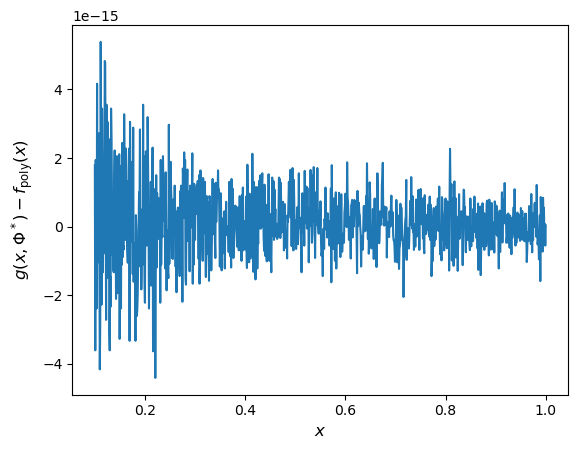

In [6]:
from qsppack.utils import chebyshev_to_func, get_entry
import matplotlib.pyplot as plt

xlist = np.linspace(1/kappa, 1, 1000)
func = lambda x: chebyshev_to_func(x, coef, parity, True)
targ_value = targ(xlist)
func_value = func(xlist)
QSP_value = get_entry(xlist, phi_proc, out)
err = np.linalg.norm(QSP_value - func_value, np.inf)
print('The residual error is')
print(err)

plt.plot(xlist, QSP_value - func_value)
plt.xlabel('$x$', fontsize=12)
plt.ylabel('$g(x,\\Phi^*)-f_\\mathrm{poly}(x)$', fontsize=12)
plt.show()

Note that the residual error above attains almost machine precision.

## Additional plots

We would like to approximate the inverse function $f(x) = \frac{1}{2\kappa x}$ by an odd polynomial $p(x)$ on the interval $[\kappa^{-1}, 1]$, and represent this polynomial using QSP. For $\kappa=10$, the following example shows one such odd polynomial of degree $d=101$ that is bounded by $1$ on $[-1,1]$. 

The QSP error is close to machine precision. The phase factors are symmetric with respect to the center of the interval after removing a factor of $\pi/4$ on both ends and decay rapidly from the center.

In [7]:
# Recalculate with higher degree for high-precision example
kappa_high = 10
deg_high = 101
parity_high = deg_high % 2

# Define target function for matrix inversion
targ_high = lambda x: 1/(2*kappa_high*x)

print(f"Condition number κ: {kappa_high}")
print(f"Degree of the approximating polynomial: {deg_high}")
print(f"Parity: {parity_high} (odd polynomial)")

# Set up optimization options for higher degree polynomial
opts_high = {
    'intervals': [1/kappa_high, 1],
    'objnorm': np.inf,
    'epsil': 0.1,  # Following MATLAB code
    'npts': 500,
    'fscale': 1,
    'isplot': False,  # Disable plotting during computation
    'method': 'cvxpy'
}

# Find best approximation polynomial using convex optimization
coef_full_high = cvx_poly_coef(targ_high, deg_high, opts_high)

# Extract odd coefficients only (due to odd parity)
coef_high = coef_full_high[parity_high::2]

print(f"Number of odd coefficients: {len(coef_high)}")

Condition number κ: 10
Degree of the approximating polynomial: 101
Parity: 1 (odd polynomial)
norm error = 1.927251413680331e-05
max of solution = 0.758781110079824
Number of odd coefficients: 51


In [8]:
# Set up solver options - use Newton method for reliable convergence
solver_opts_high = {
    'maxiter': 100,
    'criteria': 1e-12,
    'useReal': True,
    'targetPre': True,
    'method': 'Newton'
}

# Solve for phase factors
phi_proc_high, out_high = solve(coef_high, parity_high, solver_opts_high)

print(f"Converged in {out_high['iter']} iterations")

iter err          
   1  +1.1196e-01
   2  +5.8736e-03
   3  +2.3323e-05
   4  +3.8406e-10
Stop criteria satisfied.
Converged in 5 iterations


In [9]:
# Evaluate the functions for comparison
xlist_high = np.linspace(1/kappa_high, 1, 1000)
targ_value_high = targ_high(xlist_high)
func_value_high = chebyshev_to_func(xlist_high, coef_high, parity_high, True)
QSP_value_high = get_entry(xlist_high, phi_proc_high, out_high)

# Calculate errors
poly_error_high = np.linalg.norm(QSP_value_high - func_value_high, np.inf)
qsp_error_high = np.linalg.norm(QSP_value_high - targ_value_high, np.inf)

print('The QSP vs polynomial error is:', poly_error_high)
print('The QSP vs target error is:', qsp_error_high)

# Prepare phase factors with pi/4 removed from both ends
phi_shift_high = phi_proc_high.copy()
phi_shift_high[0] = phi_shift_high[0] - np.pi/4
phi_shift_high[-1] = phi_shift_high[-1] - np.pi/4

# Create extended x-list from 0 to 1 for QSP plotting (as in MATLAB code)
xlist_extend = np.linspace(0, 1, 1000)
QSP_value_extend = get_entry(xlist_extend, phi_proc_high, out_high)

The QSP vs polynomial error is: 4.163336342344337e-15
The QSP vs target error is: 2.1213282169696424e-05


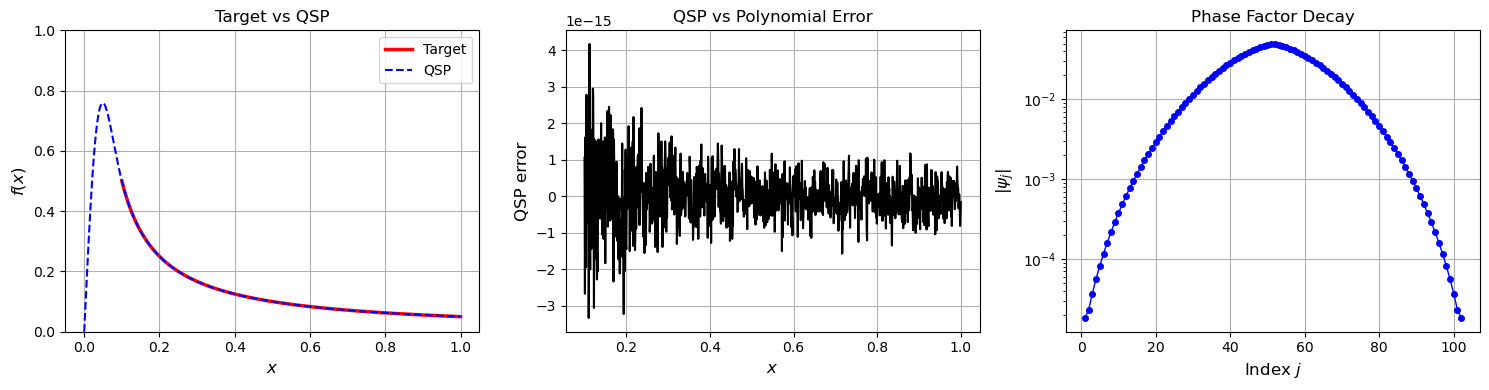

Figure saved as 'qsp_inversion.png'


In [10]:
# Generate the three-subplot figure matching the MATLAB version
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Left subplot: target function on original interval and QSP on extended interval
axes[0].plot(xlist_high, targ_value_high, 'r-', linewidth=2.5, label='Target')
axes[0].plot(xlist_extend, QSP_value_extend, 'b--', linewidth=1.5, label='QSP')
axes[0].set_xlabel('$x$', fontsize=12)
axes[0].set_ylabel('$f(x)$', fontsize=12)
axes[0].set_ylim([0, 1])
axes[0].legend(loc='best')
axes[0].grid(True)
axes[0].set_title('Target vs QSP')

# Middle subplot: error between QSP and polynomial approximation
axes[1].plot(xlist_high, QSP_value_high - func_value_high, 'k-', linewidth=1.5)
axes[1].set_xlabel('$x$', fontsize=12)
axes[1].set_ylabel('QSP error', fontsize=12)
axes[1].grid(True)
axes[1].set_title('QSP vs Polynomial Error')

# Right subplot: phase factors (after removing pi/4 factor) on log scale
axes[2].semilogy(range(1, len(phi_shift_high)+1), np.abs(phi_shift_high), 'bo-', markersize=4, linewidth=1)
axes[2].set_xlabel('Index $j$', fontsize=12)
axes[2].set_ylabel('$|\\psi_j|$', fontsize=12)
axes[2].grid(True)
axes[2].axis('tight')
axes[2].set_title('Phase Factor Decay')

plt.tight_layout()
plt.savefig('qsp_inversion.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Figure saved as 'qsp_inversion.png'")

The above figure shows the QSP representation of $f(x)=\frac{1}{2\kappa x}$ using an odd polynomial of degree $101$:

- **Left panel**: The target function on the interval $[\kappa^{-1}, 1]$ and the QSP representation extended to $[0, 1]$, showing perfect agreement on the target interval
- **Middle panel**: Error between the QSP representation and the polynomial approximation, demonstrating machine precision accuracy
- **Right panel**: Phase factors after removing a factor of $\pi/4$ on both ends, plotted on log scale, showing the characteristic symmetric decay behavior

The QSP error is close to machine precision. The phase factors exhibit symmetric decay behavior away from the center, which can be explained using the infinite quantum signal processing (iQSP) framework. This example is related to the quantum linear system problem.

## Reference

1. Gilyén, A., Su, Y., Low, G. H., & Wiebe, N. (2019, June). Quantum singular value transformation and beyond: exponential improvements for quantum matrix arithmetics. In *Proceedings of the 51st Annual ACM SIGACT Symposium on Theory of Computing* (pp. 193-204).
2. Dong, Y., Meng, X., Whaley, K. B., & Lin, L. (2021). Efficient phase-factor evaluation in quantum signal processing. *Physical Review A*, 103(4), 042419.